In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import selfies as sf
import os

In [2]:
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import MolToSmiles
from rdkit.Chem import DataStructs
from rdkit import DataStructs
from rdkit.Chem import AllChem

In [3]:
from rdkit import RDLogger

In [4]:
RDLogger.DisableLog('rdApp.*')

In [5]:
class CHEMENV:
    def __init__(self, max_actions=150):
        self.tokens = ['[#Branch1]', '[#Branch2]', '[=Branch1]', '[=Branch2]', '[=Ring1]', '[=Ring2]', '[Branch1]', '[Branch2]', '[Ring1]', '[Ring2]']
        self.tokens += ['[P]', '[O]', '[N]', '[F]', '[Cl]', '[C]', '[Br]', '[#C]', '[S]']
        self.tokens += ['[=C]', '[=N]', '[=O]', '[=P]', '[=S]', '[#N]'] #, '[=S+1]', '[=PH1]']
        # self.tokens += ['[#N+1]', '[=N+1]', '[=N-1]', '[N+1]', '[N-1]']
        # self.tokens += ['[CH1-1]', '[CH0]', '[CH1]', '[NH0]', '[NH1+1]', '[NH1]', '[O-1]', '[OH0]', '[PH0]', '[PH1]', '[S+1]', '[SH1]', '[C-1]']

        self.action_space = ['<', '>'] + self.tokens
        self.atoi = {a: i for i, a in enumerate(self.action_space)}
        self.current_state = [0]
        self.max_actions = max_actions
        self.action_count = 0

    def get_num_action(self):
        return len(self.action_space)

    def reset(self):
        self.current_state = [0]
        self.action_count = 0
        return self.current_state

    def to_index_list(self, s):
        return [self.atoi[a] for a in s]

    def to_selfies(self, s):
        selfi = "".join([self.action_space[i] for i in s])
        selfi = selfi.replace(self.action_space[1], "").replace(self.action_space[0], "")
        return selfi

    def calc_reward(self, selfies1):
        try:
            smiles1 = sf.decoder(selfies1)
        except sf.DecoderError as e:
            return False
        try:
            mol1 = MolFromSmiles(smiles1)
            if mol1 is not None:
                ms = [Chem.MolFromSmiles(smiles1), Chem.MolFromSmiles('COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC')]
                fpgen = AllChem.GetRDKitFPGenerator()
                fps = [fpgen.GetFingerprint(x) for x in ms]
                tanimoto = DataStructs.TanimotoSimilarity(fps[0],fps[1])
                return tanimoto * 5
            else:
                return 0
        except Exception as e:
            print(f"Error in calc_reward: {e}")  # Debug print
            return 0
            


    def step(self, a):
        self.current_state = self.current_state + [a]
        self.action_count += 1
        selfies_string = self.to_selfies(self.current_state)

        r = self.calc_reward(selfies_string)
        terminated = (a == 1) and (len(self.current_state) > 5)  # 최소 5자 이상 생성하는 조건 추가
        terminated = terminated or self.action_count >= self.max_actions
        return self.current_state, r, terminated, False, None

    def close(self):
        pass

In [6]:
env = CHEMENV()

env.get_num_action()

27

In [7]:
# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [8]:
# Actor 모델
class Actor(nn.Module):
    def __init__(self, num_action, embedding_dim, hidden_size):
        super(Actor, self).__init__()
        self.emb = nn.Embedding(num_action, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_size, num_layers=4, batch_first=True, dropout=0.2)  # 여러 레이어 추가
        self.fc = nn.Linear(hidden_size, num_action)

    def forward(self, state):
        ## type(state): tensor
        x = self.emb(state.unsqueeze(0))  # 배치 차원 추가
        o, h = self.rnn(x)  # o.shape: (batch, seqlen, hidden_size), h.shape: (num_layers, batch, hidden_size)
        o_last = self.fc(o[:, -1, :])  # 배치의 마지막 시퀀스 아이템
        probabilities = torch.softmax(o_last, dim=-1)
        return probabilities

# Critic 모델
class Critic(nn.Module):
    def __init__(self, num_action, embedding_dim, hidden_size):
        super(Critic, self).__init__()
        self.emb = nn.Embedding(num_action, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_size, num_layers=4, batch_first=True, dropout=0.2)  # 여러 레이어 추가
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, state):
        ## type(state): tensor
        x = self.emb(state.unsqueeze(0))  # 배치 차원 추가
        o, h = self.rnn(x)  # o.shape: (batch, seqlen, hidden_size), h.shape: (num_layers, batch, hidden_size)
        o_last = self.fc(o[:, -1, :])  # 배치의 마지막 시퀀스 아이템
        return o_last


In [9]:
def print_progress(episode, rewards, smi):
    print(f'Episode {episode + 1} / {num_episodes}\tReward = {rewards}\tSMILES: {smi}')

In [10]:
# Network and optimization
env = CHEMENV(max_actions=150)
actor = Actor(env.get_num_action(), 16, 32).to(device)
critic = Critic(env.get_num_action(), 16, 32).to(device)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

In [11]:
# GAE parameters
gamma = 0.99  # discount factor
lambda_gae = 0.95  # GAE lambda

# Training loop
num_episodes = 3000
print_interval = 100
rewards_list = []

In [12]:
checkpoint_dir = 'checkpoints/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

for episode in range(1, num_episodes):
    state = env.reset()
    done = False
    episode_rewards = 0
    state_values = []
    rewards = []
    masks = []
    actions = []
    states = []
    action_log_probs = []

    while not done:
        state_tensor = torch.IntTensor(state).to(device)
        probs = actor(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        episode_rewards += reward

        # Store information
        states.append(state_tensor)
        actions.append(action)
        action_log_probs.append(dist.log_prob(action))
        rewards.append(reward)
        masks.append(1 - done)

        state_value = critic(state_tensor)
        state_values.append(state_value)

        state = next_state

    rewards_list.append(episode_rewards)

    next_state_tensor = torch.IntTensor(state).to(device)
    next_state_value = critic(next_state_tensor)

    returns = []
    gae = 0
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * next_state_value * masks[step] - state_values[step]
        gae = delta + gamma * lambda_gae * masks[step] * gae
        next_state_value = state_values[step]
        returns.insert(0, gae + state_values[step])

    returns = torch.stack(returns)
    state_values = torch.stack(state_values)
    actions = torch.stack(actions)
    action_log_probs = torch.stack(action_log_probs)

    advantages = returns - state_values

    # Update Critic
    critic_loss = (returns - state_values).pow(2).mean()
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

    # Update Actor
    actor_loss = -(action_log_probs * advantages.detach()).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    if (episode + 1) % print_interval == 0:
        smi = sf.decoder(env.to_selfies(state))
        print_progress(episode, episode_rewards, smi)
        ms = [Chem.MolFromSmiles(smi), Chem.MolFromSmiles('COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC')]
        fpgen = AllChem.GetRDKitFPGenerator()
        fps = [fpgen.GetFingerprint(x) for x in ms]
        tanimoto = DataStructs.TanimotoSimilarity(fps[0],fps[1])

        print(f"TanimotoSimilarity : {tanimoto}")
        
        # 모델 상태 저장
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{episode + 1}.pth')
        torch.save({
            'actor_state_dict': actor.state_dict(),
            'critic_state_dict': critic.state_dict(),
            'optimizer_actor_state_dict': actor_optimizer.state_dict(),
            'optimizer_critic_state_dict': critic_optimizer.state_dict(),
            'episode': episode + 1
        }, checkpoint_path)
        print(f"Checkpoint saved at episode {episode + 1}")

# Close the environment
env.close()

Episode 100 / 3000	Reward = 4.243960148710453	SMILES: ClC(C=S#CO)F
TanimotoSimilarity : 0.029342723004694836
Checkpoint saved at episode 100
Episode 200 / 3000	Reward = 2.377257069782281	SMILES: SP#CCl
TanimotoSimilarity : 0.009626955475330927
Checkpoint saved at episode 200
Episode 300 / 3000	Reward = 15.33972790044647	SMILES: C=C=NNN=C=O
TanimotoSimilarity : 0.021352313167259787
Checkpoint saved at episode 300
Episode 400 / 3000	Reward = 0.0	SMILES: OBr
TanimotoSimilarity : 0.0
Checkpoint saved at episode 400
Episode 500 / 3000	Reward = 0.0	SMILES: OBr
TanimotoSimilarity : 0.0
Checkpoint saved at episode 500
Episode 600 / 3000	Reward = 2.674698795180715	SMILES: FS=O
TanimotoSimilarity : 0.0036144578313253013
Checkpoint saved at episode 600
Episode 700 / 3000	Reward = 36.27727064767996	SMILES: P=CC=NOC=C=COC=NOS=O
TanimotoSimilarity : 0.05339265850945495
Checkpoint saved at episode 700
Episode 800 / 3000	Reward = 0.8997584541062831	SMILES: CCl
TanimotoSimilarity : 0.001207729468599033

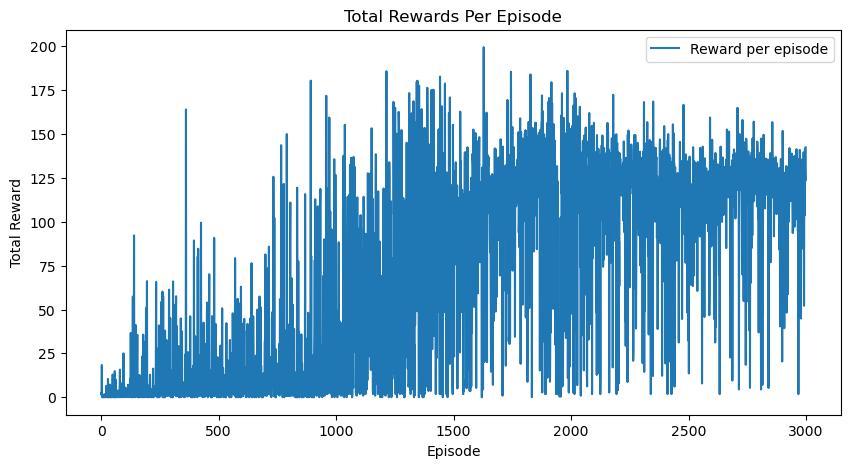

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards_list, label='Reward per episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards Per Episode')
plt.legend()
plt.show()